In [1]:
! pip install kneed

In [2]:
!pip install clusteval

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f11461dc23a9f638945ad4126769f77e11b439abe66dc9cb9b9ac3fe0ec7c17b
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


## Importing Necessary Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.decomposition import PCA
from datetime import date

### Defining customization parameters

In [7]:
plt.rcParams['figure.figsize']=(12,8)
pd.set_option('display.float_format', lambda x: '%.2f' %x)

### Loading the Dataset

In [8]:
df = pd.read_csv('C:\\Users\\HP\\Downloads\\kaggle\\bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


### Understanding the data

In [9]:
df.shape

(1048567, 9)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [11]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


In [12]:
df.describe(include='object')

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,TransactionDate
count,1048567,1048567,1045170,1047467,1048416,1048567
unique,1048567,884265,17254,3,9355,55
top,T1,C5533885,1/1/1800,M,MUMBAI,7/8/16
freq,1,6,57339,765530,103595,27261


In [13]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [14]:
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [15]:
df[df.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)


### Feature Engineering / Feature Extraction

In [16]:
df.drop(['TransactionID','CustomerID'], axis = 1, inplace=True)

In [17]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

In [18]:
#Creating New Feature Age from CustomerDOB
def age(dob):
    y = date.today().year
    m = date.today().month
    age = y - dob.year -(m < dob.month)
    return age

In [19]:
df['CustomerAge'] = df['CustomerDOB'].apply(age)

In [20]:
df.head(2)

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,1994-10-01,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00,28.00
1,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.00,-35.00


In [21]:
df = df[df['CustomerAge']> 0]

In [22]:
df.drop(['CustomerDOB'], axis = 1, inplace = True)

In [23]:
df['CustomerAge'].isnull().sum()

0

In [24]:
df['CustGender'].value_counts()

M    702164
F    257835
T         1
Name: CustGender, dtype: int64

In [25]:
df[df['CustGender']=='T']

,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
959987,T,CHENNAI,50050.00,10/9/16,170731,32500.00,223.00


In [29]:
df =  df[~(df['CustGender']=='T')]

In [30]:
df['CustGender'].unique()

array(['F', 'M', nan], dtype=object)

In [31]:
df['CustGender'].isnull().sum()

886

In [32]:
df = df[~(df['CustGender'].isnull())]

In [33]:
df['CustLocation'].isnull().sum()

151

In [34]:
df = df[~(df['CustLocation'].isnull())]

In [37]:
df['CustAccountBalance'].isnull().sum()

2177

In [38]:
df['CustAccountBalance'] = df.groupby('CustLocation')['CustAccountBalance'].transform('mean')

In [39]:
df['CustAccountBalance'].isnull().sum()

160

In [41]:
df = df[~df['CustAccountBalance'].isna()]

In [42]:
df.isnull().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
CustomerAge                0
dtype: int64

In [43]:
df.drop(['TransactionTime'], axis =1, inplace = True)

In [44]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [46]:
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

In [47]:
df['TransactionMonthName'] = df['TransactionDate'].dt.month_name()
df['TransactionDayName'] = df['TransactionDate'].dt.day_name()

In [52]:
df.drop(['TransactionDate'], axis =1, inplace=True)

In [51]:
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionMonth,TransactionDay,TransactionMonthName,TransactionDayName
0,F,JAMSHEDPUR,45581.38,25.00,28.00,2,8,February,Monday
2,F,MUMBAI,137238.31,459.00,26.00,2,8,February,Monday
3,F,MUMBAI,137238.31,2060.00,49.00,2,8,February,Monday
4,F,NAVI MUMBAI,109838.18,1762.50,35.00,2,8,February,Monday
6,F,MUMBAI,137238.31,566.00,31.00,2,8,February,Monday


### Exploratory Data Analysis

### Uni-Variate Analysis

([<matplotlib.patches.Wedge at 0x24f8032d9a0>,
 [Text(-0.7974908240412371, 0.8966651468469312, 'M'),
  Text(0.7310331784152683, -0.8219431197206231, 'F')],
 [Text(-0.4652029806907216, 0.5230546689940432, '73.14%'),
  Text(0.39874537004469174, -0.44833261075670344, '26.86%')])

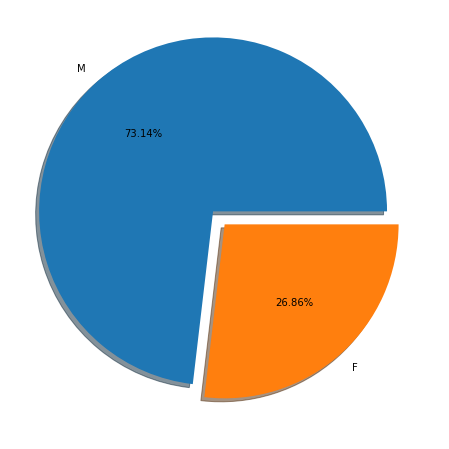

In [56]:
values = df['CustGender'].value_counts().values
labels = df['CustGender'].value_counts().keys()

plt.pie(values, labels= labels, explode=(0.1,0), shadow= True, autopct='%1.2f%%')

#### Observation: around 73% of customers are males and 27% are females

<AxesSubplot:xlabel='CustomerAge', ylabel='Density'>

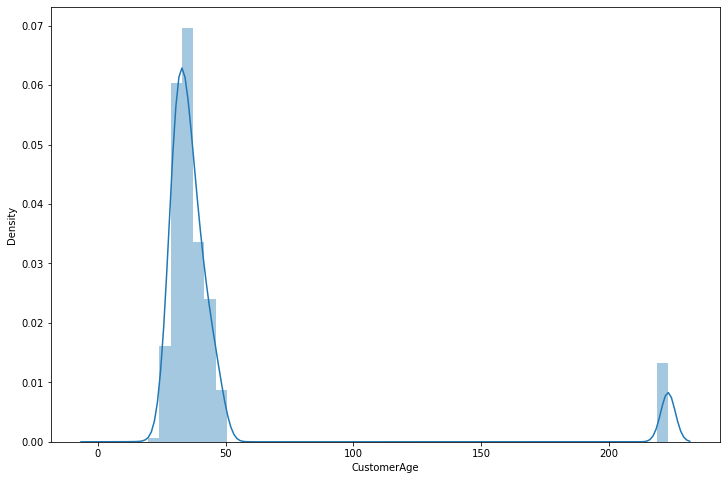

In [60]:
sns.distplot(df['CustomerAge'] )

#### Observation: an outlier at 222, and most of the customers lie in the range of 0-55 

<AxesSubplot:xlabel='TransactionDayName', ylabel='count'>

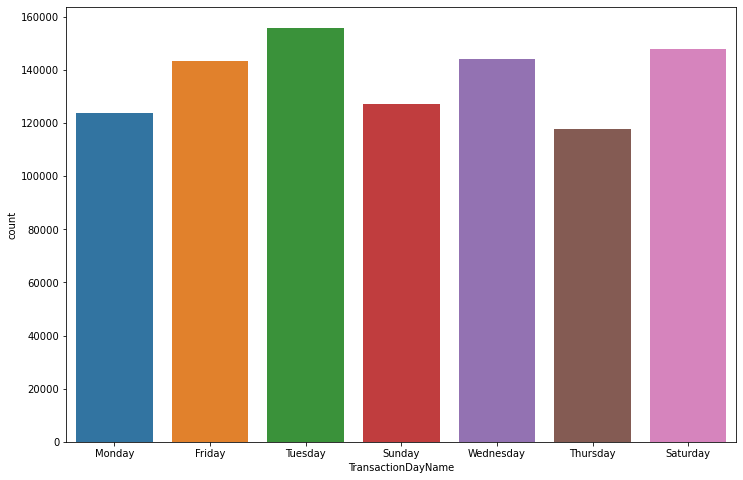

In [62]:
sns.countplot(x='TransactionDayName', data=df)

#### Observation: almost equal number of transaction in all days of week. No of transactions were highest on Tuesdays

<AxesSubplot:xlabel='TransactionMonthName', ylabel='count'>

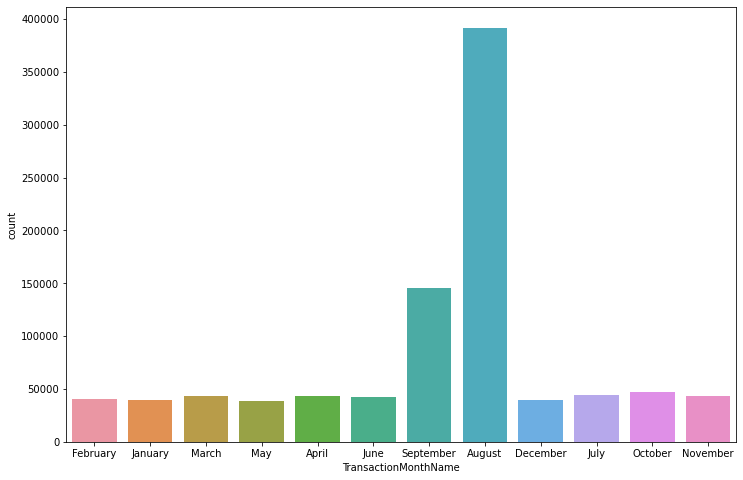

In [63]:
sns.countplot(x='TransactionMonthName', data=df)

#### Obseravtion: highest transactions were done in the months of August and September

skewness of CustAccountBalance:  85.15259022781856
kurtosis of CustAccountBalance:  12872.78229267982
Distribution plot of CustAccountBalance: 


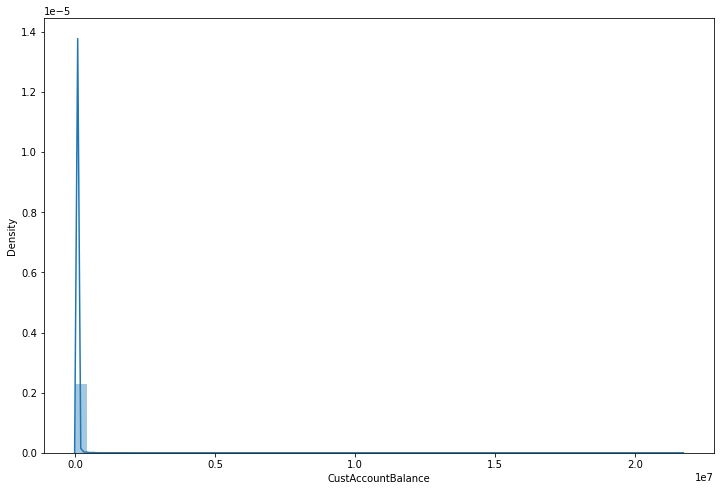

Box plot of CustAccountBalance:


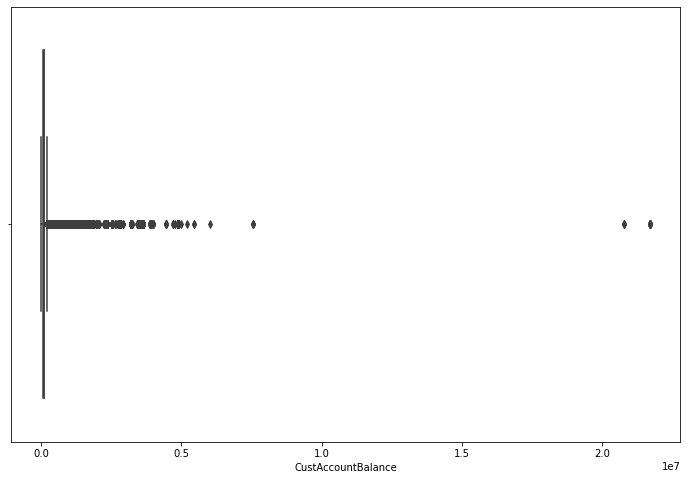

skewness of TransactionAmount (INR):  56.972533113151364
kurtosis of TransactionAmount (INR):  9565.222497905634
Distribution plot of TransactionAmount (INR): 


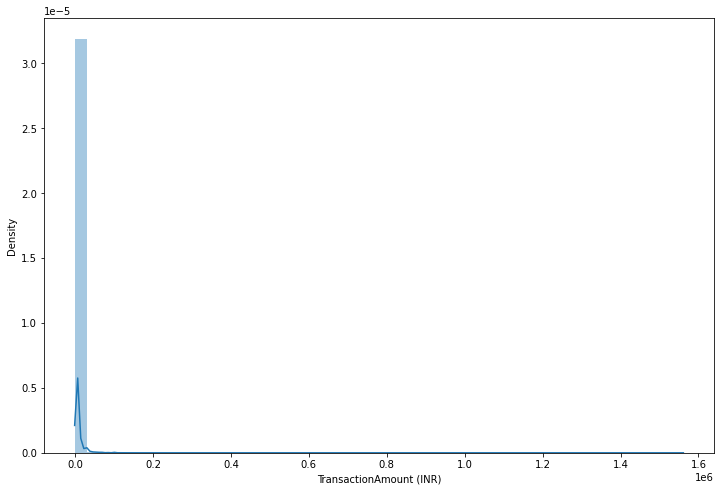

Box plot of TransactionAmount (INR):


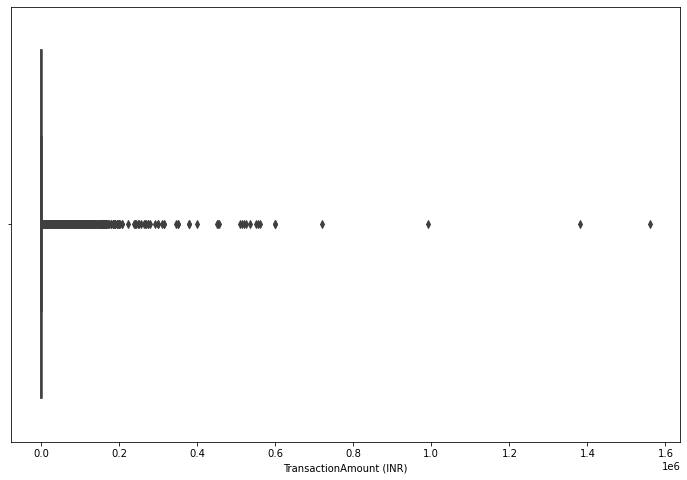

skewness of CustomerAge:  3.6587565834611095
kurtosis of CustomerAge:  11.63351582064692
Distribution plot of CustomerAge: 


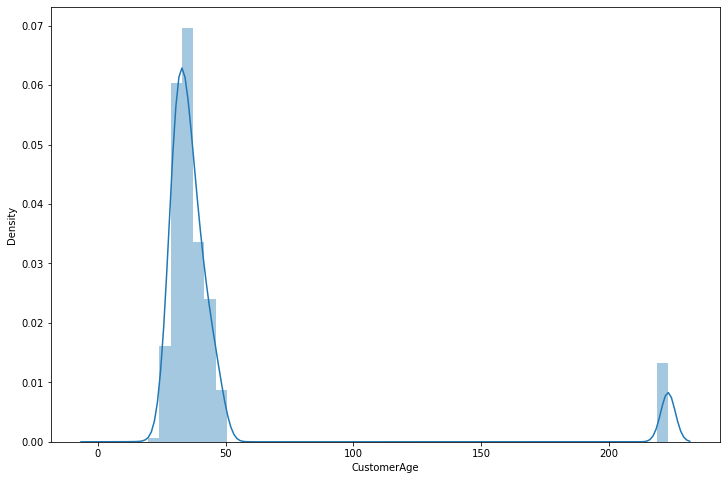

Box plot of CustomerAge:


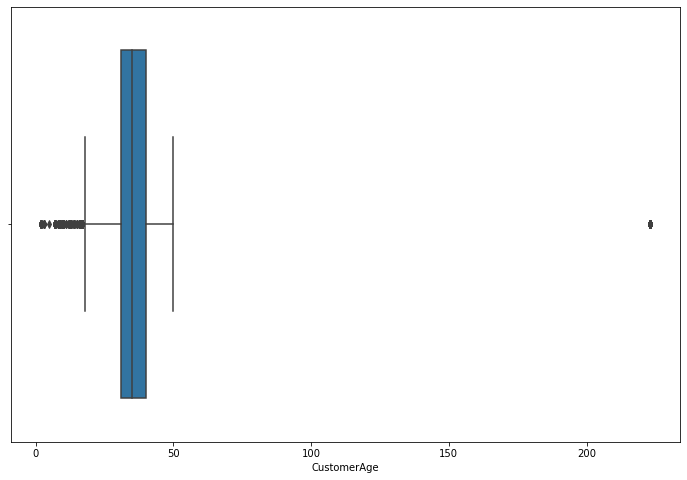

In [64]:
for col in df.columns:
    if df[col].dtypes == 'float64':
        print('skewness of {}: '.format(col), df[col].skew())
        print('kurtosis of {}: '.format(col), df[col].kurt())
        print('Distribution plot of {}: '.format(col))
        sns.distplot(df[col])
        plt.show()
        print('Box plot of {}:'.format(col))
        sns.boxplot(x=col, data = df)
        plt.show()
        

### Bi-variate Analysis:

<AxesSubplot:xlabel='CustGender'>

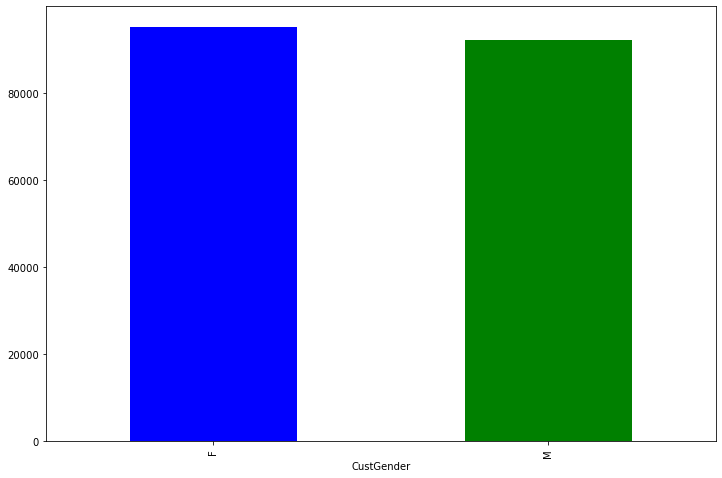

In [65]:
df.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar', color=['blue', 'green'])

#### Observation: Females account balance is more compared to Males

<AxesSubplot:xlabel='CustGender'>

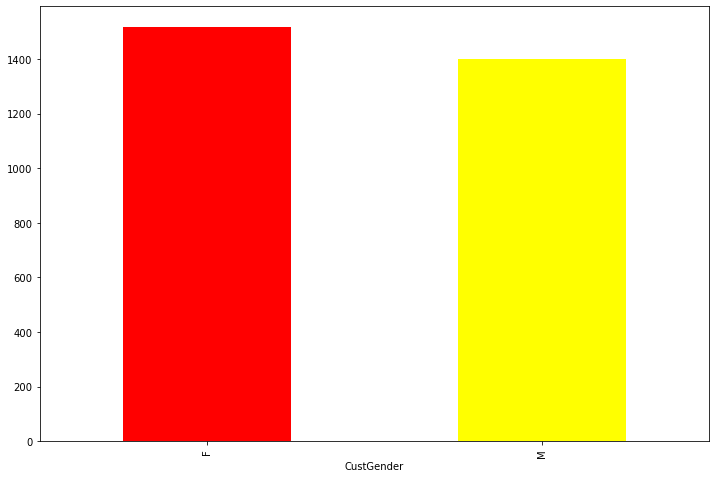

In [69]:
df.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar', color=['red', 'yellow'])

#### Observation: Females transaction amount is more compared to male transaction amount

<AxesSubplot:xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

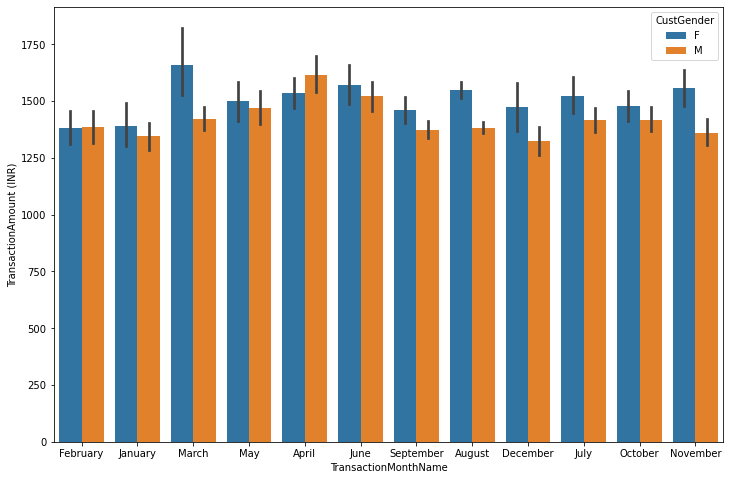

In [70]:
sns.barplot(x='TransactionMonthName', y='TransactionAmount (INR)', data=df, hue='CustGender')

#### Observation: Female customers had made large amount of transactions compared to Males except in February and April months

<AxesSubplot:xlabel='TransactionDayName', ylabel='TransactionAmount (INR)'>

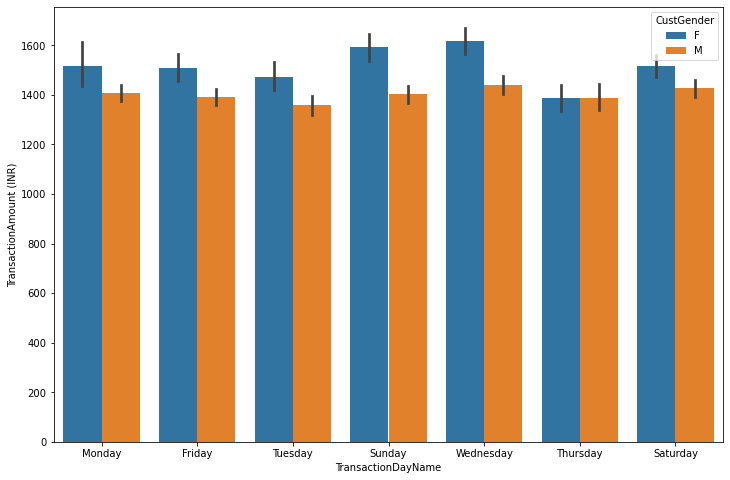

In [71]:
sns.barplot(x='TransactionDayName', y = 'TransactionAmount (INR)', data=df,hue='CustGender')

#### Observation: Females have made more amount of transactions in all days of week

In [72]:
df['CustomerAge'].nunique()

48

Text(0.5, 1.0, 'Top 10 Customer Locations and Mean Transaction Amount (INR)')

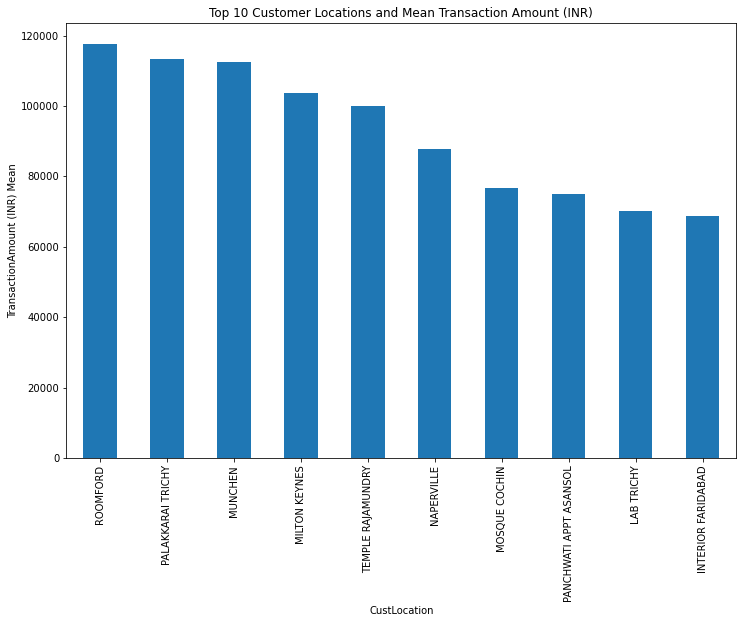

In [81]:
df.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar')
plt.ylabel('TransactionAmount (INR) Mean')
plt.title('Top 10 Customer Locations and Mean Transaction Amount (INR)')

#### Observation: Customers belonging to the Roomford bank branch in United Kingdom mostly perform the highest transactions which are closely followed by the bank branches in Palakkarai Trichy(Tamil Nadu, India) and Munchen in Germany.

Text(0.5, 1.0, 'Top 10 Customer Locations and Customer Account Balance')

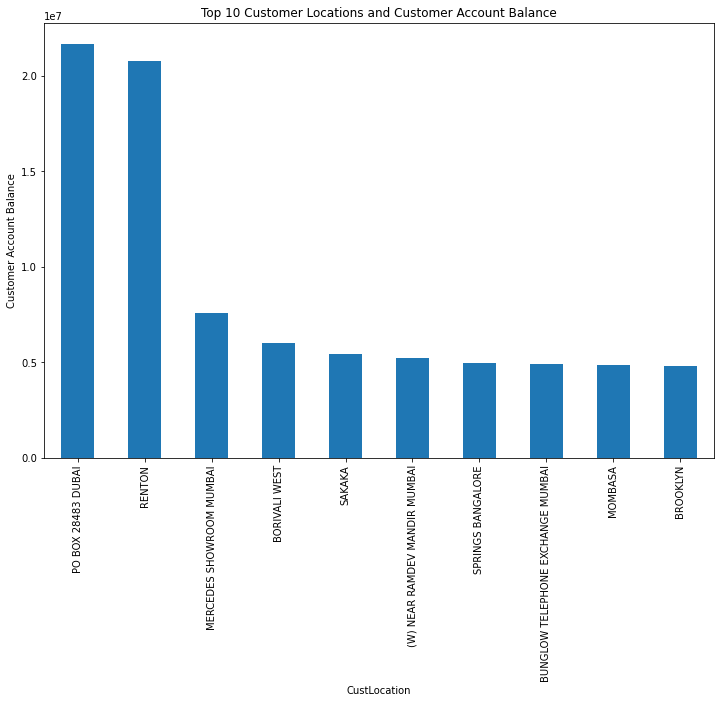

In [84]:
df.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar')
plt.ylabel('Customer Account Balance')
plt.title('Top 10 Customer Locations and Customer Account Balance')

#### Observation: customers living at PO BOX 28483 Dubai have highest account balance among others followed by Renton

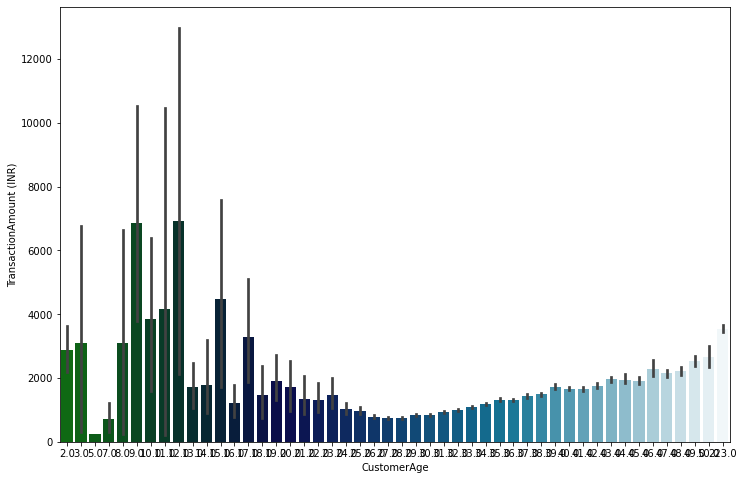

<Figure size 6000x2400 with 0 Axes>

In [92]:
sns.barplot(x= 'CustomerAge', y='TransactionAmount (INR)', data=df, palette='ocean')
plt.figure(figsize=(30, 12), dpi=200)
plt.show()


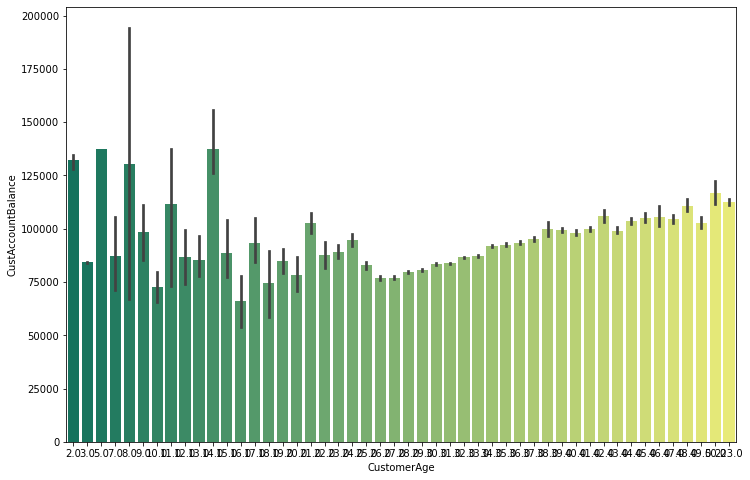

<Figure size 864x864 with 0 Axes>

In [91]:
sns.barplot(x= 'CustomerAge', y='CustAccountBalance', data=df, palette='summer')
plt.figure(figsize=(12, 12))
plt.show()


<AxesSubplot:>

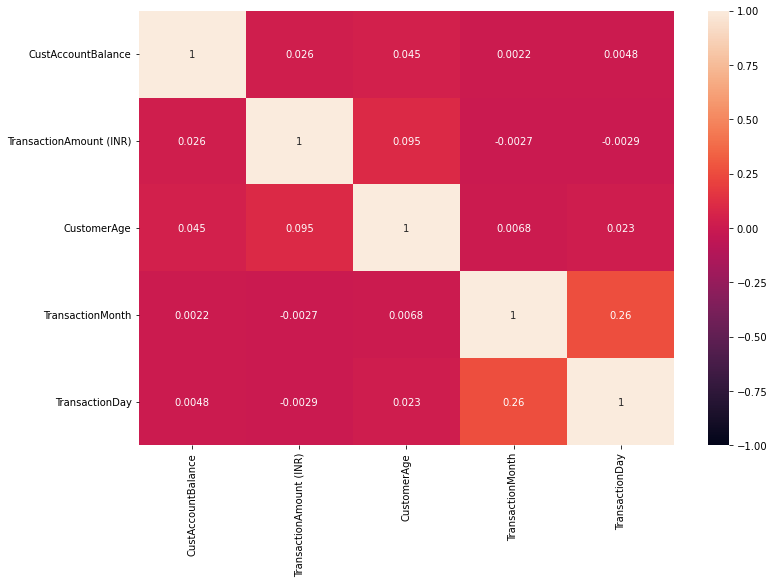

In [94]:
sns.heatmap(df.corr(),annot= True, vmin=-1, vmax =1)

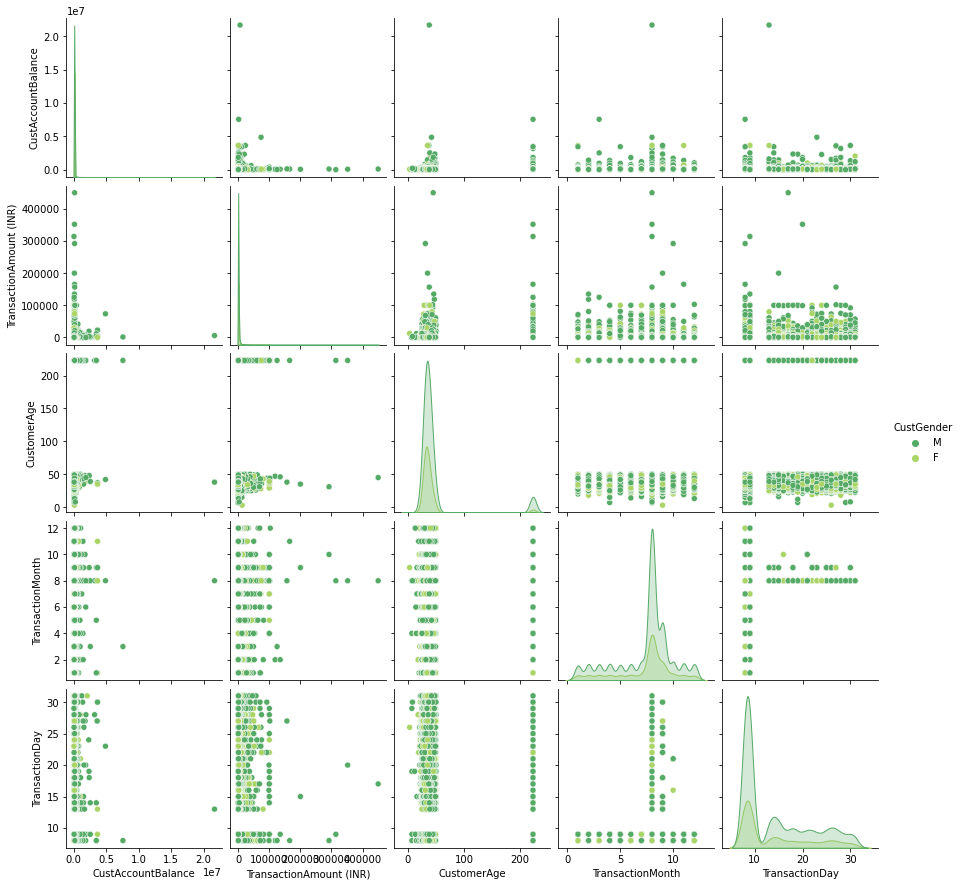

In [95]:
sns.pairplot(df.sample(n=50000),hue='CustGender',palette='summer')

#### Encoding of Categorical Features

In [96]:
df['CustomerGender'] = np.where(df['CustGender']=='M', 1,0)

In [97]:
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionMonth,TransactionDay,TransactionMonthName,TransactionDayName,CustomerGender
0,F,JAMSHEDPUR,45581.38,25.00,28.00,2,8,February,Monday,0
2,F,MUMBAI,137238.31,459.00,26.00,2,8,February,Monday,0
3,F,MUMBAI,137238.31,2060.00,49.00,2,8,February,Monday,0
4,F,NAVI MUMBAI,109838.18,1762.50,35.00,2,8,February,Monday,0
6,F,MUMBAI,137238.31,566.00,31.00,2,8,February,Monday,0


In [98]:
encoder = LabelEncoder()
df['CustLocation'] = encoder.fit_transform(df['CustLocation'])

In [99]:
df.dtypes

CustGender                  object
CustLocation                 int32
CustAccountBalance         float64
TransactionAmount (INR)    float64
CustomerAge                float64
TransactionMonth             int64
TransactionDay               int64
TransactionMonthName        object
TransactionDayName          object
CustomerGender               int32
dtype: object

In [100]:
#changing the dtype of CustLocation and CustomerGender to int64

df['CustomerGender'] = df['CustomerGender'].astype('int64')
df['CustLocation'] = df['CustLocation'].astype('int64')

In [101]:
df.dtypes

CustGender                  object
CustLocation                 int64
CustAccountBalance         float64
TransactionAmount (INR)    float64
CustomerAge                float64
TransactionMonth             int64
TransactionDay               int64
TransactionMonthName        object
TransactionDayName          object
CustomerGender               int64
dtype: object

In [102]:
# Deleting features of type object64
df.drop(['CustGender', 'TransactionMonthName', 'TransactionDayName'], axis= 1, inplace =True)

In [104]:
# Standardization using StandardScaler
scale = StandardScaler()
df = scale.fit_transform(df)
df

array([[-0.22584183, -0.37180105, -0.23331141, ..., -2.02773238,
        -0.87938814, -1.65010234],
       [ 0.47854083,  0.34835897, -0.16137099, ..., -2.02773238,
        -0.87938814, -1.65010234],
       [ 0.47854083,  0.34835897,  0.10401293, ..., -2.02773238,
        -0.87938814, -1.65010234],
       ...,
       [-0.30296074,  0.17772089, -0.10981921, ...,  0.62684521,
         0.49211919,  0.60602302],
       [ 2.10476357, -0.01230612, -0.0716941 , ...,  0.62684521,
         0.49211919,  0.60602302],
       [ 1.08338629, -0.01701376, -0.04417771, ...,  0.62684521,
         0.49211919,  0.60602302]])

In [108]:
#changing the array to dataframe
df = pd.DataFrame(df, columns = ['CustLocation', 'CustAccountBalance', 'TransactionAmount (INR)', 'CsutomerAge', 'TransactionMonth', 'TransactionDay', 'CustomerGender'])
df.head()

,CustLocation,CustAccountBalance,TransactionAmount (INR),CsutomerAge,TransactionMonth,TransactionDay,CustomerGender
0,-0.23,-0.37,-0.23,-0.41,-2.03,-0.88,-1.65
1,0.48,0.35,-0.16,-0.46,-2.03,-0.88,-1.65
2,0.48,0.35,0.10,0.06,-2.03,-0.88,-1.65
3,0.64,0.13,0.05,-0.25,-2.03,-0.88,-1.65
4,0.48,0.35,-0.14,-0.34,-2.03,-0.88,-1.65


### Model Building: Unsupervised Machine Learning Model

#### K-Means Clustering


In [111]:
# here real data is huge, hence we build model using samples of 50000.

smdf = df.sample(50000, random_state =1)

In [114]:
smdf.shape

(50000, 7)

In [127]:
iner_ll=[]
iner_el=[]
al = {}
for k in range(2,15):
    for algo in ['lloyd', 'elkan']:
        model = KMeans(n_clusters = k, init='k-means++', algorithm=algo)
        model = model.fit(smdf)
        if algo =='lloyd':
            iner_ll.append(model.inertia_)
        else:
            iner_el.append(model.inertia_)
al['lloyd']= iner_ll
al['elkan'] = iner_el
            

In [128]:
al

{'lloyd': [304418.0091053489,
  256603.67325340386,
  221928.55355243536,
  193151.8524525396,
  167887.4130581721,
  146990.0226871019,
  132591.29346610472,
  118449.40383651454,
  107779.46023625313,
  100073.83637774126,
  93011.92431272422,
  85323.33615539604,
  81743.49886732713],
 'elkan': [304417.58578601904,
  256603.67325340386,
  221928.52517378842,
  193151.8238006052,
  167886.417215855,
  146844.12584840495,
  132623.08547352575,
  123288.18518721273,
  107776.52202831293,
  100074.49813079479,
  93693.07077033102,
  85975.521058098,
  79633.4898063332]}

<AxesSubplot:>

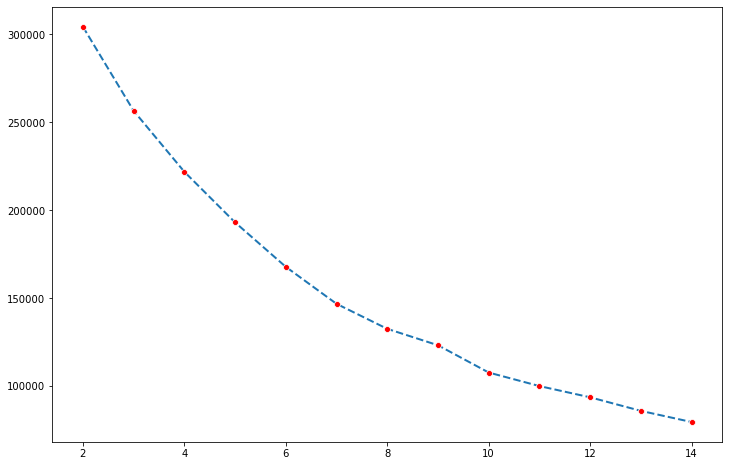

In [140]:
sns.lineplot(x= range(2,15), y=al['elkan'], marker='o', ls='--', lw = 2, markerfacecolor='red', ms=6)

<AxesSubplot:>

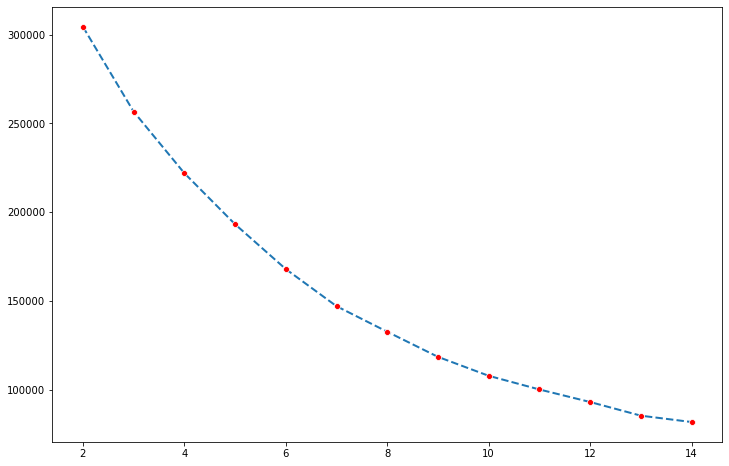

In [142]:
sns.lineplot(x= range(2,15), y=al['lloyd'], marker='o', ls='--', lw = 2, markerfacecolor='red', ms=6)

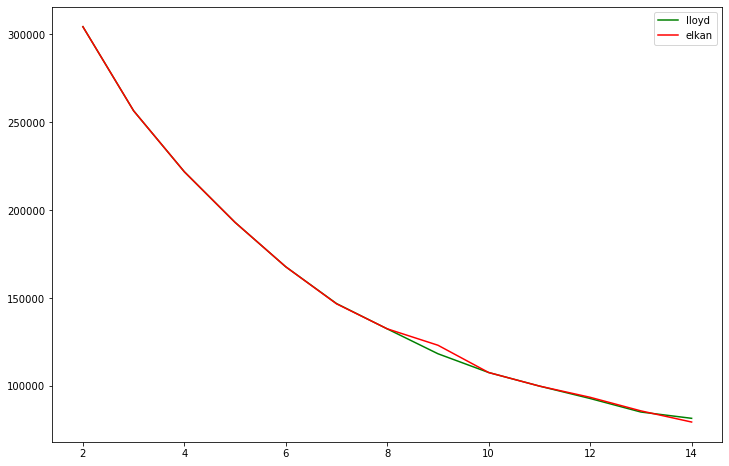

In [160]:
plt.plot(range(2,15), al['lloyd'],'g', label='lloyd')
plt.plot(range(2,15), al['elkan'], 'r', label='elkan')
plt.legend()

In [161]:
# as per number of clusters and inertia plot, best params as with n_clusters = 10 and algorithm as 'elkan'

model = KMeans(init='k-means++',algorithm='elkan', n_clusters=10)
model = model.fit(smdf)
predictions = model.labels_


In [ ]:
# Calculaton of silhouete error for these parameters
se = silhouette_score(smdf,model.labels_)